In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import os
from joblib import dump, load

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

## Problem Description

The problem at hand consists of detecting metastatic cancer in small batches of larger digital pathology scans. The batches have .tif format and we can handle the problem as a image recognition task. The area of the patches that is important for the classification task are the center 32x32 pixels. This is because the authors of the competetion wanted to ensure that also models without zero padding will yield defined results according to predefined values in the outer regions of the batches.
The task of the model that we have to develop is to classify each batch as either "1" cancer detected or "0" no cancer cells detected.

The training set of the data consists of 220,000 .tif images. Whereas the test set is smaller with 57500 images. Each labeled batch has 96 by 96 pixels and therefore a quite small value of around 30 kB, with the exact size depending on the specific content of each batch. Each pixel does have RGB valued color information, which means that our input dataset has a total dimension of 96x96x3. Where three describes the depth dimension.

## EDA

The given dataset is clean and already equally formatted in 96x96 pixel images, as described above. So we do not have to perform any data cleaning steps.

In [2]:
labels = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
labels['label'].unique()

array([0, 1])

Furthermore the output above shows, that also the labels are clean, as there are only zeros and ones present in the respective column of the csv file. This means, that there are no unclassified images in the training data.

In the following we will plot one batch from the training set to get a better sense of the task and the data.

Text(0.5, 1.0, 'Blue')

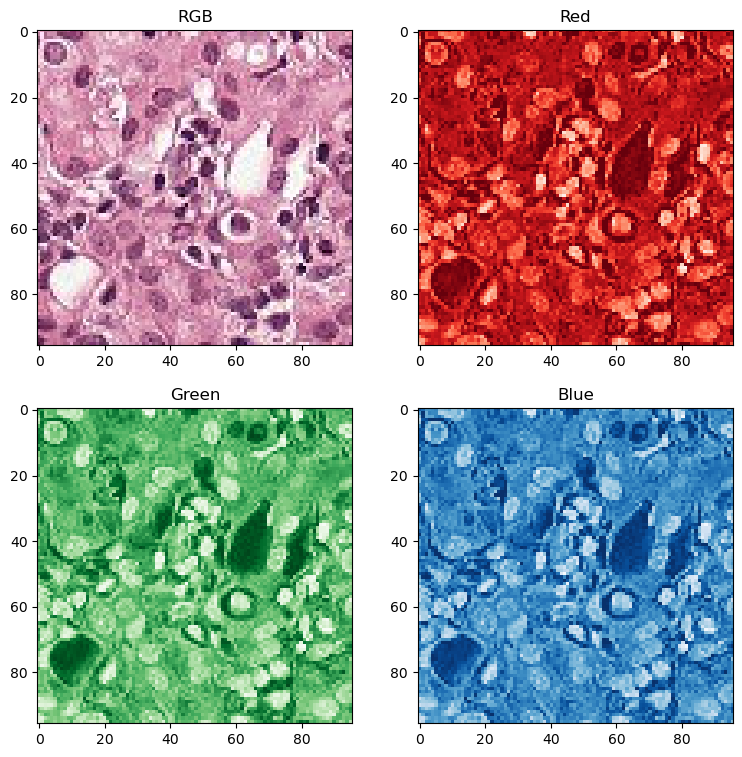

In [3]:
example_image =mpimg.imread('/kaggle/input/histopathologic-cancer-detection/train/00001b2b5609af42ab0ab276dd4cd41c3e7745b5.tif')
#imgplot = 
#imgplot2 = 

fig, axs = plt.subplots(2, 2, figsize=(9,9))
axs[0, 0].imshow(example_image)
axs[0, 0].set_title('RGB')
axs[0, 1].imshow(example_image[:,:,0],cmap='Reds')
axs[0, 1].set_title('Red')
axs[1, 0].imshow(example_image[:,:,1],cmap='Greens')
axs[1, 0].set_title('Green')
axs[1, 1].imshow(example_image[:,:,2],cmap='Blues')
axs[1, 1].set_title('Blue')

The plots show the original RGB image together with the single color channels of the image. We can see the cells on the picture and can imagine, that the detection of malicious cells will depend on the structure of the cells alone and in relation to each other.

In a final EDA step I will plot a classical intensity histgram known from photography of the example batch. It will show how the tonal intensity is distributed. To that end I will calculate the mean RGB-values of each channel an use it as an input for the histogram. This input can be compared in its meaning to a greyscale value.

Text(0, 0.5, '# of pixels')

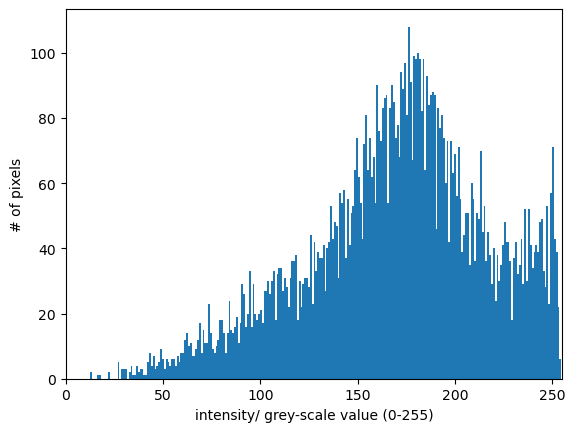

In [4]:
hist_vals = example_image.mean(axis=2).flatten()
b, bins, patches = plt.hist(hist_vals, 255)
plt.xlim([0,255])
plt.xlabel('intensity/ grey-scale value (0-255)')
plt.ylabel('# of pixels')

The picture shows that the distribution of greyscale values is a bit skewed to the right of the possible field. Which means that it is rather bright. Moreover, we can see that the intensity values range from 0 to 255, which is therefore also true for each color channel on its own. This marks the range of possible input values for our model.

Our plan of action is to take the training images and use them as an input for a convolutional neural network. In the model building step we will try different combinations of neural layers but will focus on a combination of convolutinal layers with small filter sizes like 3x3x3, maxpool layers followed by a dense multi or single layer perceptron classifier. We use multiple small filters, as we have learned in the lectures, that they are more efficient than larger ones.

## Model Building, Comparison and Hyper Parameter Tuning

### Input Workflow

First of all, we have to start our model building workflow by preparing the input data. As we have shown above, the data is already clean. So we can instantiate the whole dataset in our ML-model. As we are using keras in combination with tensorflow, we will follow the workflow on the keras website to prepare the model (https://keras.io/examples/vision/image_classification_from_scratch/). Moreover, the tensorflow help page (https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is of great hepl in the creation of an input pipeline.

First we will use the keras ImageDataGenerator API and its methods to load the data, which are in our case images in batches of 32. We will explain the code to load the input data in more detail. The codes for the validation and test data are equivalent. First we define a dataframe, that stores both the names of the images and the label (0 or 1) in its respective columns. We will use these columns in x_col and y_col. Furthermore, we set the root working directory, where the images will be searched according to the names and set the target_size of the images to be equivalent to the aforementioned input size of the images (96x96 pixels). As the images are stored in RGB format, we choose color_mode "RGB". Moreover, we have binary class labels and want to produce a reproducible shuffle, which is why we set a seed. Finally we define the subset that is defined by the command, which is "training" in this case to correspond with the validation_split in the DataGenerator class and choose, that we do not want to validate the filenames, as we expect them to be correct. This should save computing ressources according to the manual.

In [5]:
mapping_train_inputs = pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv')
mapping_train_inputs["names"] = mapping_train_inputs["id"] + '.tif'
mapping_train_inputs["targets_bin"] = mapping_train_inputs["label"].astype(str)

test_names = os.listdir("/kaggle/input/histopathologic-cancer-detection/test")
mapping_test_inputs = pd.DataFrame()
mapping_test_inputs["names"] = test_names

# Input values between 0 and 1 are sad to be beneficial for optimization -> rescale

imgdatgen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255, validation_split=0.2)

train_generator = imgdatgen.flow_from_dataframe(
        dataframe=mapping_train_inputs,
        directory='/kaggle/input/histopathologic-cancer-detection/train',
        x_col='names',
        y_col='targets_bin',
        target_size=(96, 96),
        color_mode='rgb',
        #batch_size=32,
        class_mode='binary',
        shuffle=True,
        seed=42,
        subset='training',
        validate_filenames=False)

val_generator = imgdatgen.flow_from_dataframe(
        dataframe=mapping_train_inputs,
        directory='/kaggle/input/histopathologic-cancer-detection/train',
        x_col='names',
        y_col='targets_bin',
        target_size=(96, 96),
        color_mode='rgb',
        #batch_size=32,
        class_mode='binary',
        shuffle=True,
        seed=42,
        subset='validation',
        validate_filenames=False)

test_generator = imgdatgen.flow_from_dataframe(
        dataframe=mapping_test_inputs,
        directory='/kaggle/input/histopathologic-cancer-detection/test',
        x_col='names',
        y_col=None,
        target_size=(96, 96),
        color_mode='rgb',
        #batch_size=32,
        class_mode=None,
        shuffle=False,
        seed=42,
        validate_filenames=False)

Found 176020 non-validated image filenames belonging to 2 classes.
Found 44005 non-validated image filenames belonging to 2 classes.
Found 57458 non-validated image filenames.


According to our subsample size we have to the define the steps per epoch, as well as the steps for the validation. They are the result of dividing the total number of images by the sample size. The below performed floor division will remove any non integer rest remaining after the division.

In [6]:
training_steps = 176020//32
validation_steps = 44005//32

### Model Architecture

As a first attempt we will start to implement the typical CNN architecture described in this course. This architecture combines multiple instances of a combination of two convolutional layers with small filter sizes and a maxpool layer. After these mulitple convolution steps there will be dense fully connected layers of the flattened input array and a final sigmoid activation before the output. In detail we will start with the LeNet 5 architecture from 1998. This architectural design should work as due to the different convolutional stages the model will be able to train on smaller an larger focus areas of the pictures. Furthermore the pooling layers should reduce the noise, associated with any kind of image data. The final sigmoid activation is necessary to receive a result for our binary classification problem. 

The first layer that we have to implement however, is a cropping layer. The reason for that lies in the problem description of the Kaggle competition. It says the only the center 32x32 pixels of the batches are relevant for the classification task. So we have to crop the input batches (32+a x 32+a) pixels, where a is the amount of pixels being additionally necessary depending on the filter size. This course of action allows us to use consistent, predefined data, given in the task, and makes padding unnecessary.

In [7]:
def LeNet5(input_shape = (96, 96, 3),first_filter_size=3, num_repeat_conv_pool=2, conv_stride=1, conv_f_size=5, conf_f_num=(6,16), pool_size=2, num_dense=3, sizes_dense=(120,84,1)):
    # Input-Layer - Instanting Keras Tensor of size input_shape
    X_input = tf.keras.Input(input_shape) 
    # Cropping-Layer - Reducing the batch size in accordance to the filter size of the first conv layer and the relevant are given in the task
    
    # ToDo: Make Cropping Adaptable depending on filter size
    
    X = tf.keras.layers.Cropping2D(cropping=((30,30),(30,30)))(X_input)
    # First Conv Layer with input_shape as an argument
    X = tf.keras.layers.Conv2D(conf_f_num[0],conv_f_size,conv_stride,padding='valid',activation='tanh',input_shape=input_shape)(X)
    # First Max Pool Layer
    X = tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=None)(X)
    # Following Combination of Conv and Max Pool Layer
    for i in range(num_repeat_conv_pool-1):
        X = tf.keras.layers.Conv2D(conf_f_num[i+1],conv_f_size,conv_stride,padding='valid', activation='tanh')(X)
        X = tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=None)(X)
    # Flattening of the Output of the Conv-Pool Layer Combinations as Input for fully connected layers
    X = tf.keras.layers.Flatten()(X)
    # Fully connected dense layers
    for i in range(num_dense-1):
        X = tf.keras.layers.Dense(sizes_dense[i], activation='tanh')(X)
    # Output layer with sigmoid activation function
    X= tf.keras.layers.Dense(sizes_dense[-1],activation='sigmoid')(X)
    
    model = tf.keras.Model(inputs = X_input, outputs = X)
    
    return(model)

The section creating our first model, as well as the compilation and training history are commented out in this version of the notebook, as they ran over night in the kaggle environment. However, we saved the results back into the kaggle working directories, so that we can use them to visualize the performance of our model. We are loading the before created results in the subsequent cell.

In [ ]:
#model = LeNet5(input_shape = (96, 96, 3))
#print(model.summary())
#model.compile(optimizer= tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), metrics=['accuracy'])
#history = model.fit(
#    train_generator,
#    steps_per_epoch = training_steps,
#    validation_data = val_generator,
#    validation_steps = validation_steps,
#    epochs = 20,
#    verbose = 2
#)
#dump(model, '/kaggle/working/first_model.joblib')
#dump(history, '/kaggle/working/history_first_model.joblib')

In [8]:
training_hist_first_model = load('/kaggle/input/cancer-detection-models/history_first_model-2.joblib')

Text(0.5, 1.0, 'Loss')

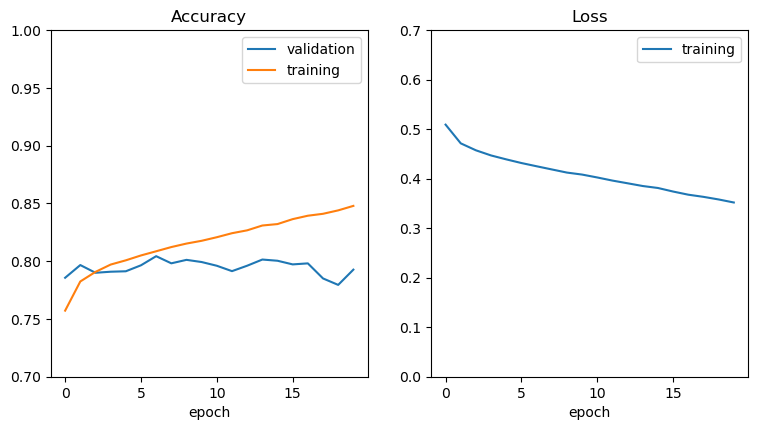

In [9]:
epochs = list(range(len(training_hist_first_model.history['val_accuracy'])))
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
axs[0].plot(epochs,training_hist_first_model.history['val_accuracy'],label='validation')
axs[0].plot(epochs,training_hist_first_model.history['accuracy'],label='training')
axs[0].set_xlabel('epoch')
axs[0].set_ylim(0.70,1)
axs[0].legend()
axs[0].set_title('Accuracy')
axs[1].plot(epochs,training_hist_first_model.history['loss'],label='training')
axs[1].set_xlabel('epoch')
axs[1].set_ylim(0.00,0.7)
axs[1].legend()
axs[1].set_title('Loss')

We can see in our plots, that our first model reaches a quite good validation accuracy of slightly more than 80% in the sixth epoch of learning.
Furthermore we can observe that our validation accuracy strongly trails our training accuracy with increasing epoch count, which is a strong indicator of overfitting.
Finally our loss does not show a asymptotic behaviour to a stationary value. This is often caused by a learning rate that is to low.
We have to consider that the amount of training epochs is relatively low in our study. This is necessary because of the limited computing power, that we have available and causes the "wigly" behaviour of the validation accurarcy. This accuracy would get more constant with increasing epoch count.

### Optimization of Learning Hyper Parameters

As a next step we will try to start a hyperparameter study for the learning parameters of our model, which are the learning algorithm and the learning rate. We will test the RMSProp Algorithm against our standard Adam algorithm as well as learning rates ranging from 0.01 to 0.0001 for the Adam algorithm and compare the results in the coming plots. Again we ran the model overnight and are re-loading the results in the next cells.

In [ ]:
#model_alt_learn = LeNet5(input_shape = (96, 96, 3))
#model_alt_learn.compile(optimizer= tf.keras.optimizers.experimental.RMSprop(), loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), metrics=['accuracy'])
#history_alt_learn = model_alt_learn.fit(
#    train_generator,
#    steps_per_epoch = training_steps,
#    validation_data = val_generator,
#    validation_steps = validation_steps,
#    epochs = 10,
#    verbose = 2
#)
#dump(model_alt_learn, '/kaggle/working/model_alt_learn.joblib')
#dump(history_alt_learn, '/kaggle/working/history_alt_learn.joblib')

In [ ]:
#models_learning_rate = {}
#histories_learning_rate = {}
#for rate in [0.01, 0.0001]:
#    models_learning_rate[rate] = LeNet5(input_shape = (96, 96, 3))
#    models_learning_rate[rate].compile(optimizer= tf.keras.optimizers.experimental.Adam(learning_rate=rate), loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), metrics=['accuracy'])
#    histories_learning_rate[rate] = models_learning_rate[rate].fit(
#        train_generator,
#        steps_per_epoch = training_steps,
#        validation_data = val_generator,
#        validation_steps = validation_steps,
#        epochs = 10,
#        verbose = 2
#    )
#dump(models_learning_rate, '/kaggle/working/model_alt_learning_rate.joblib')
#dump(histories_learning_rate, '/kaggle/working/history_alt_learning_rate.joblib')

In [10]:
training_hists_alt_learn_model = load('/kaggle/input/cancer-detection-models/history_alt_learn.joblib')
training_hists_alt_learning_rate = load('/kaggle/input/cancer-detection-models/history_alt_learning_rate.joblib')

Text(0.5, 1.0, 'Loss')

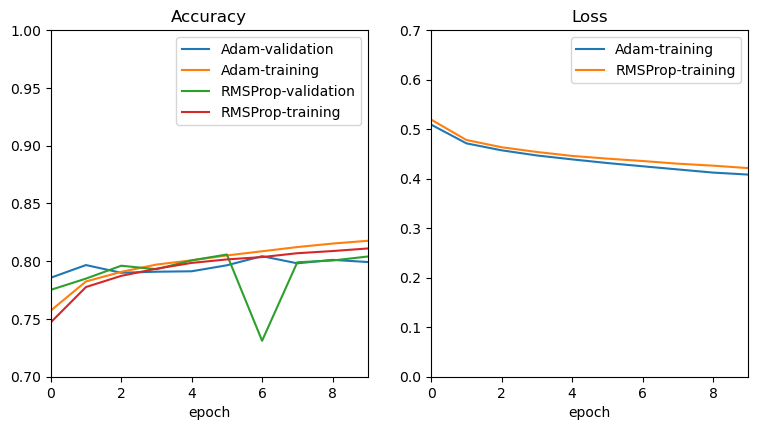

In [11]:
epochs = list(range(len(training_hist_first_model.history['val_accuracy'])))
epochs_alt = list(range(len(training_hists_alt_learn_model.history['val_accuracy'])))
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
axs[0].plot(epochs,training_hist_first_model.history['val_accuracy'],label='Adam-validation')
axs[0].plot(epochs,training_hist_first_model.history['accuracy'],label='Adam-training')
axs[0].plot(epochs_alt,training_hists_alt_learn_model.history['val_accuracy'],label='RMSProp-validation')
axs[0].plot(epochs_alt,training_hists_alt_learn_model.history['accuracy'],label='RMSProp-training')
axs[0].set_xlabel('epoch')
axs[0].set_ylim(0.70,1)
axs[0].set_xlim(0,9)
axs[0].legend()
axs[0].set_title('Accuracy')
axs[1].plot(epochs,training_hist_first_model.history['loss'],label='Adam-training')
axs[1].plot(epochs_alt,training_hists_alt_learn_model.history['loss'],label='RMSProp-training')
axs[1].set_xlabel('epoch')
axs[1].set_ylim(0.00,0.7)
axs[1].set_xlim(0,9)
axs[1].legend()
axs[1].set_title('Loss')

That plots show, that the Adam algorithms performance is superior to the RMSProps, due to the following features of the diagnostic plots. First the loss of the RMSProp algorithm during training is consistently higher, which indicates a stronger deviation from the target values. Furthermore, there is a strong fluctuation in the development of the validation accuracy of the RMSProp powered model, which is indicated in the sharp decline during the 6th epoch. We will continue our optimization with the Adam algorithm and try different learning rates in the next step. 

Text(0.5, 1.0, 'Loss')

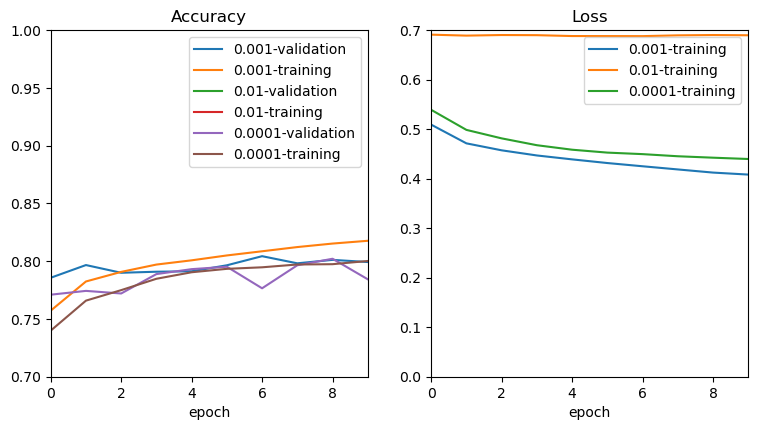

In [12]:
epochs = list(range(len(training_hist_first_model.history['val_accuracy'])))
epochs_alt = list(range(len(training_hists_alt_learn_model.history['val_accuracy'])))
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
axs[0].plot(epochs,training_hist_first_model.history['val_accuracy'],label='0.001-validation')
axs[0].plot(epochs,training_hist_first_model.history['accuracy'],label='0.001-training')
axs[0].plot(epochs_alt,training_hists_alt_learning_rate[0.01].history['val_accuracy'],label='0.01-validation')
axs[0].plot(epochs_alt,training_hists_alt_learning_rate[0.01].history['accuracy'],label='0.01-training')
axs[0].plot(epochs_alt,training_hists_alt_learning_rate[0.0001].history['val_accuracy'],label='0.0001-validation')
axs[0].plot(epochs_alt,training_hists_alt_learning_rate[0.0001].history['accuracy'],label='0.0001-training')
axs[0].set_xlabel('epoch')
axs[0].set_ylim(0.70,1)
axs[0].set_xlim(0,9)
axs[0].legend()
axs[0].set_title('Accuracy')
axs[1].plot(epochs,training_hist_first_model.history['loss'],label='0.001-training')
axs[1].plot(epochs_alt,training_hists_alt_learning_rate[0.01].history['loss'],label='0.01-training')
axs[1].plot(epochs_alt,training_hists_alt_learning_rate[0.0001].history['loss'],label='0.0001-training')
axs[1].set_xlabel('epoch')
axs[1].set_ylim(0.00,0.7)
axs[1].set_xlim(0,9)
axs[1].legend()
axs[1].set_title('Loss')

The plots show, that a learning rate of 0.01 is way to high, which is shown by the fact, that loss is not decreasing during the epochs. The other rates are performing quite similar, which is why we are sticking with the higher rate of 0.001, as this will lead to faster convergence during our limited amount of epochs.

### Optimization of Model Hyper Parameters

Finally we will start some hyperparameter optimization for the model parameters while sticking with our best learning algorithm (Adam, learning rate: 0.001).

We will try to optimize the following features of our model architecture and try different architectures in detail in this course: Number of repeated convolution and pooling layers, Convolution stride, Number of filters in the convolution layers, Pooling size, Number of dense classification layers, Size of each classification layer.

In [ ]:
# num_repeat_conv_pool, conv_stride, conv_f_num (tuple), pool size, num dense, sizes dense (tuple)
#param_comb = [['1',2, 1, (6,16), 2, 3, (120,84,1)],
#              ['2',3, 1, (6,16,26), 2, 3, (120,84,1)],
#              ['3',2, 2, (6,16), 2, 3, (120,84,1)],
#              ['4',2, 1, (6,16), 2, 2, (120,1)],
#              ['5',2, 1, (6,16), 2, 4, (240,120,84,1)],
#              ['6',2, 1, (6,16), 4, 3, (120,84,1)]]

#models_param_tuning = {}
#histories_param_tuning = {}
#for params in param_comb:
#    models_param_tuning[params[0]] = LeNet5(input_shape = (96, 96, 3),first_filter_size=3, num_repeat_conv_pool=params[1], conv_stride=params[2], conv_f_size=5, conf_f_num=params[3], pool_size=params[4], num_dense=params[5], sizes_dense=params[6])
#    models_param_tuning[params[0]].compile(optimizer= tf.keras.optimizers.experimental.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), metrics=['accuracy'])
#    histories_param_tuning[params[0]] = models_param_tuning[params[0]].fit(
#        train_generator,
#        steps_per_epoch = training_steps,
#        validation_data = val_generator,
#        validation_steps = validation_steps,
#        epochs = 10,
#        verbose = 2
#    )
#dump(models_param_tuning, '/kaggle/working/model_alt_learning_rate.joblib')
#dump(histories_param_tuning, '/kaggle/working/history_alt_learning_rate.joblib')

In [21]:
histories_param_tuning = load('/kaggle/input/cancer-detection-models/histories_param_tuning.joblib')

First we will have a look on a comparison of different numbers of conv-pooling layer pairs, comparing two and three pairs.

Text(0.5, 1.0, 'Loss')

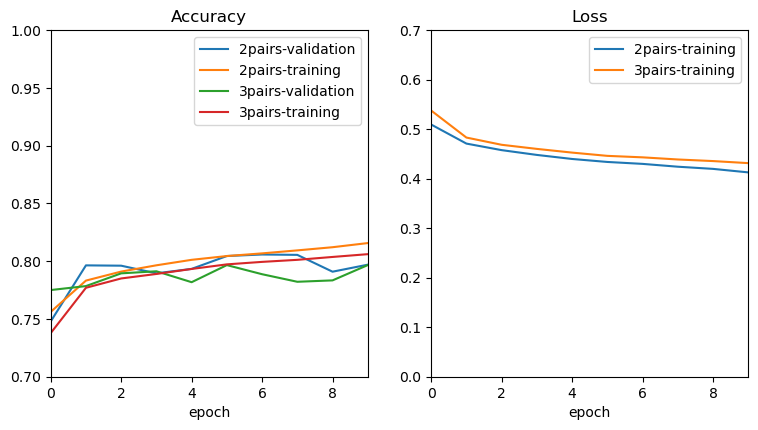

In [14]:
epochs = list(range(len(histories_param_tuning['1'].history['val_accuracy'])))
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
axs[0].plot(epochs,histories_param_tuning['1'].history['val_accuracy'],label='2pairs-validation')
axs[0].plot(epochs,histories_param_tuning['1'].history['accuracy'],label='2pairs-training')
axs[0].plot(epochs,histories_param_tuning['2'].history['val_accuracy'],label='3pairs-validation')
axs[0].plot(epochs,histories_param_tuning['2'].history['accuracy'],label='3pairs-training')
axs[0].set_xlabel('epoch')
axs[0].set_ylim(0.70,1)
axs[0].set_xlim(0,9)
axs[0].legend()
axs[0].set_title('Accuracy')
axs[1].plot(epochs,histories_param_tuning['1'].history['loss'],label='2pairs-training')
axs[1].plot(epochs,histories_param_tuning['2'].history['loss'],label='3pairs-training')
axs[1].set_xlabel('epoch')
axs[1].set_ylim(0.00,0.7)
axs[1].set_xlim(0,9)
axs[1].legend()
axs[1].set_title('Loss')

We see, that our initial version with two layer pairs performs better with consistently higher validation accuracy and lower loss.

Next we will check the effect of different convolution strides comparing a strid of 1 with a stride of 2.

Text(0.5, 1.0, 'Loss')

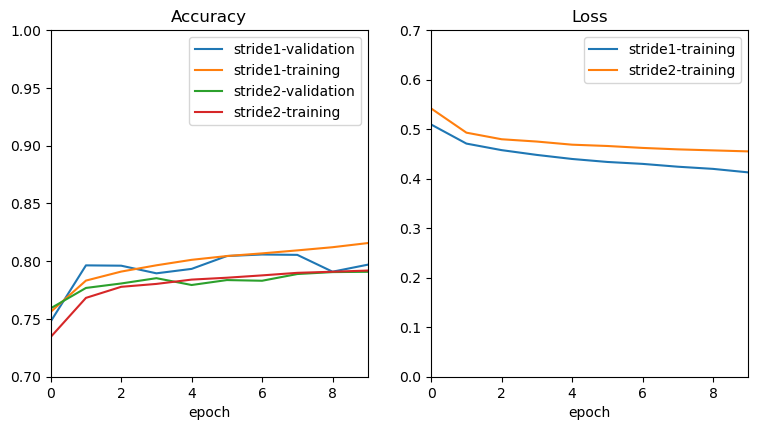

In [15]:
epochs = list(range(len(histories_param_tuning['1'].history['val_accuracy'])))
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
axs[0].plot(epochs,histories_param_tuning['1'].history['val_accuracy'],label='stride1-validation')
axs[0].plot(epochs,histories_param_tuning['1'].history['accuracy'],label='stride1-training')
axs[0].plot(epochs,histories_param_tuning['3'].history['val_accuracy'],label='stride2-validation')
axs[0].plot(epochs,histories_param_tuning['3'].history['accuracy'],label='stride2-training')
axs[0].set_xlabel('epoch')
axs[0].set_ylim(0.70,1)
axs[0].set_xlim(0,9)
axs[0].legend()
axs[0].set_title('Accuracy')
axs[1].plot(epochs,histories_param_tuning['1'].history['loss'],label='stride1-training')
axs[1].plot(epochs,histories_param_tuning['3'].history['loss'],label='stride2-training')
axs[1].set_xlabel('epoch')
axs[1].set_ylim(0.00,0.7)
axs[1].set_xlim(0,9)
axs[1].legend()
axs[1].set_title('Loss')

Again we see, that our initial version with stride one performs better with consistently higher validation accuracy and lower loss. Next, we compare the effect of different numbers and sizes of classification layers.

Text(0.5, 1.0, 'Loss')

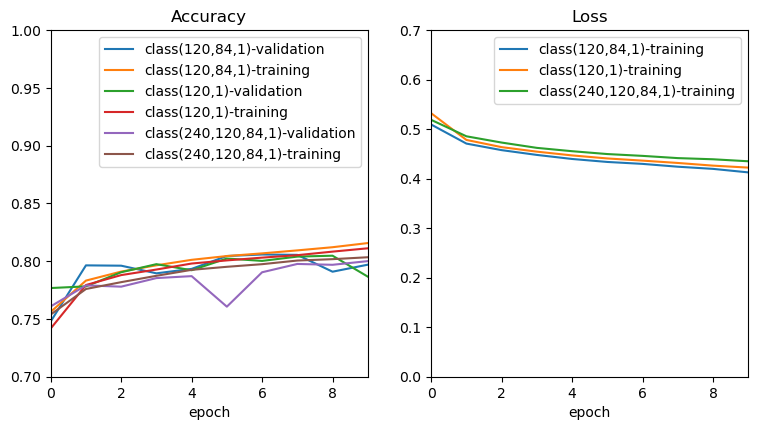

In [16]:
epochs = list(range(len(histories_param_tuning['1'].history['val_accuracy'])))
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
axs[0].plot(epochs,histories_param_tuning['1'].history['val_accuracy'],label='class(120,84,1)-validation')
axs[0].plot(epochs,histories_param_tuning['1'].history['accuracy'],label='class(120,84,1)-training')
axs[0].plot(epochs,histories_param_tuning['4'].history['val_accuracy'],label='class(120,1)-validation')
axs[0].plot(epochs,histories_param_tuning['4'].history['accuracy'],label='class(120,1)-training')
axs[0].plot(epochs,histories_param_tuning['5'].history['val_accuracy'],label='class(240,120,84,1)-validation')
axs[0].plot(epochs,histories_param_tuning['5'].history['accuracy'],label='class(240,120,84,1)-training')
axs[0].set_xlabel('epoch')
axs[0].set_ylim(0.70,1)
axs[0].set_xlim(0,9)
axs[0].legend()
axs[0].set_title('Accuracy')
axs[1].plot(epochs,histories_param_tuning['1'].history['loss'],label='class(120,84,1)-training')
axs[1].plot(epochs,histories_param_tuning['4'].history['loss'],label='class(120,1)-training')
axs[1].plot(epochs,histories_param_tuning['5'].history['loss'],label='class(240,120,84,1)-training')
axs[1].set_xlabel('epoch')
axs[1].set_ylim(0.00,0.7)
axs[1].set_xlim(0,9)
axs[1].legend()
axs[1].set_title('Loss')

Again we see, that our initial version with two hidden classification layers performs better with consistently higher validation accuracy and lower loss. Finally, we compare the effect of different pooling sizes.

Text(0.5, 1.0, 'Loss')

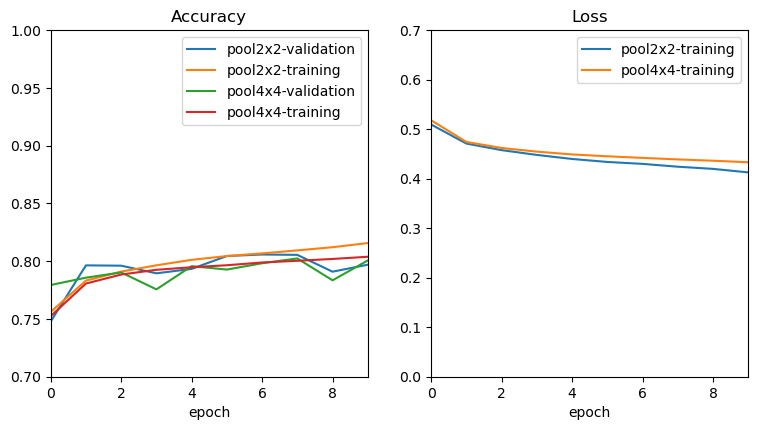

In [17]:
epochs = list(range(len(histories_param_tuning['1'].history['val_accuracy'])))
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
axs[0].plot(epochs,histories_param_tuning['1'].history['val_accuracy'],label='pool2x2-validation')
axs[0].plot(epochs,histories_param_tuning['1'].history['accuracy'],label='pool2x2-training')
axs[0].plot(epochs,histories_param_tuning['6'].history['val_accuracy'],label='pool4x4-validation')
axs[0].plot(epochs,histories_param_tuning['6'].history['accuracy'],label='pool4x4-training')
axs[0].set_xlabel('epoch')
axs[0].set_ylim(0.70,1)
axs[0].set_xlim(0,9)
axs[0].legend()
axs[0].set_title('Accuracy')
axs[1].plot(epochs,histories_param_tuning['1'].history['loss'],label='pool2x2-training')
axs[1].plot(epochs,histories_param_tuning['6'].history['loss'],label='pool4x4-training')
axs[1].set_xlabel('epoch')
axs[1].set_ylim(0.00,0.7)
axs[1].set_xlim(0,9)
axs[1].legend()
axs[1].set_title('Loss')

This final comparison again shows that the model with the original LeNet5 design works best in terms of validation accuracy, overfitting and development of the loss during training.

As a final step, we will take this original model and try to change the activation function of all hidden layers to relu, which should yield good results according to the lecture. Furthermore we will add some batch normalization layers after all hidden layers to reduce overfitting. In this way single parameters can not grow to much, which should inhibit the "specialization" of the algorithm for specific inputs values from the training set.

In [18]:
def LeNet5_Mod(input_shape = (96, 96, 3),first_filter_size=3, num_repeat_conv_pool=2, conv_stride=1, conv_f_size=5, conf_f_num=(6,16), pool_size=2, num_dense=3, sizes_dense=(120,84,1)):
    # Input-Layer - Instanting Keras Tensor of size input_shape
    X_input = tf.keras.Input(input_shape) 
    # Cropping-Layer - Reducing the batch size in accordance to the filter size of the first conv layer and the relevant are given in the task
    
    # ToDo: Make Cropping Adaptable depending on filter size
    
    X = tf.keras.layers.Cropping2D(cropping=((30,30),(30,30)))(X_input)
    # First Conv Layer with input_shape as an argument
    X = tf.keras.layers.Conv2D(conf_f_num[0],conv_f_size,conv_stride,padding='valid',activation='relu',input_shape=input_shape)(X)
    # Added Batch Normalizatino layer
    X = tf.keras.layers.BatchNormalization(synchronized=True)(X)
    # First Max Pool Layer
    X = tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=None)(X)
    # Following Combination of Conv and Max Pool Layer
    for i in range(num_repeat_conv_pool-1):
        X = tf.keras.layers.Conv2D(conf_f_num[i+1],conv_f_size,conv_stride,padding='valid', activation='relu')(X)
        # Added Batch Normalizatino layer
        X = tf.keras.layers.BatchNormalization(synchronized=True)(X)
        X = tf.keras.layers.MaxPooling2D(pool_size=pool_size,strides=None)(X)
    # Flattening of the Output of the Conv-Pool Layer Combinations as Input for fully connected layers
    X = tf.keras.layers.Flatten()(X)
    # Fully connected dense layers
    for i in range(num_dense-1):
        X = tf.keras.layers.Dense(sizes_dense[i], activation='relu')(X)
        # Added Batch Normalizatino layer
        X = tf.keras.layers.BatchNormalization(synchronized=True)(X)
    # Output layer with sigmoid activation function
    X= tf.keras.layers.Dense(sizes_dense[-1],activation='sigmoid')(X)
    
    model = tf.keras.Model(inputs = X_input, outputs = X)
    
    return(model)

In [ ]:
#final_model = LeNet5_Mod(input_shape = (96, 96, 3))
#final_model.compile(optimizer= tf.keras.optimizers.Adam(), loss=tf.keras.losses.BinaryCrossentropy(from_logits = False), metrics=['accuracy'])
#final_history = final_model.fit(
#    train_generator,
#    steps_per_epoch = training_steps,
#    validation_data = val_generator,
#    validation_steps = validation_steps,
#    epochs = 100,
#    verbose = 2
#)#
#
#dump(final_model, '/kaggle/working/final_model.joblib')
#dump(final_history, '/kaggle/working/final_history.joblib')

In [22]:
histories_final = load('/kaggle/input/cancer-detection-models2/final_history.joblib')

For this final, tweaked model we will observe some more epochs of the learning procedure (100).

Text(0.5, 1.0, 'Loss')

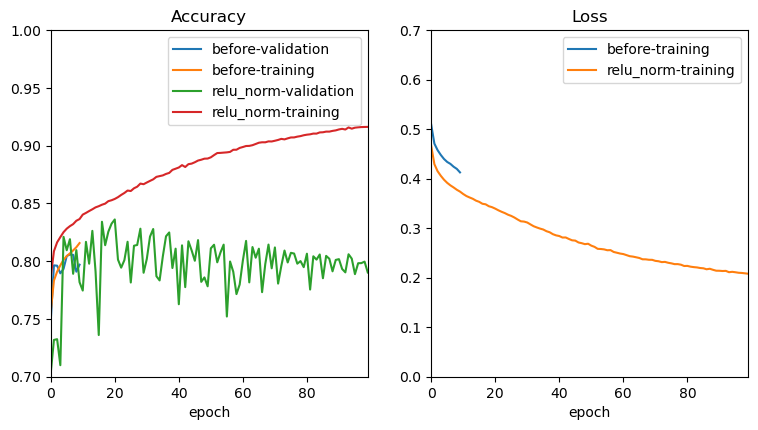

In [24]:
epochs = list(range(len(histories_param_tuning['1'].history['val_accuracy'])))
epochs_max = list(range(len(histories_final.history['val_accuracy'])))
fig, axs = plt.subplots(1, 2, figsize=(9,4.5))
axs[0].plot(epochs,histories_param_tuning['1'].history['val_accuracy'],label='before-validation')
axs[0].plot(epochs,histories_param_tuning['1'].history['accuracy'],label='before-training')
axs[0].plot(epochs_max,histories_final.history['val_accuracy'],label='relu_norm-validation')
axs[0].plot(epochs_max,histories_final.history['accuracy'],label='relu_norm-training')
axs[0].set_xlabel('epoch')
axs[0].set_ylim(0.70,1)
axs[0].set_xlim(0,99)
axs[0].legend()
axs[0].set_title('Accuracy')
axs[1].plot(epochs,histories_param_tuning['1'].history['loss'],label='before-training')
axs[1].plot(epochs_max,histories_final.history['loss'],label='relu_norm-training')
axs[1].set_xlabel('epoch')
axs[1].set_ylim(0.00,0.7)
axs[1].set_xlim(0,99)
axs[1].legend()
axs[1].set_title('Loss')

We can observe, that the model with batch normalization after each hidden layer and relu activation in these layers performs slightly better than the original LeNet5 model. This confirms the guidance given in the lecture, that these are appropriate steps to improve the performance of a convolutional neural network for image recognition tasks. We can see that this new final model, has consistently lower loss during training and reaches a maximum validation accuracy of about 84%. After around 20 epochs the model begins to strongly overfit, which is shown by the decreasing validation accuracy, as well as the increasing gap between both accuracies.

To summarize our hyperparamter tuning procedure, we can say, that we optimized both learning and model parameters ranging from the kind of learning method, over the learning rate, filter sizes, amount of convolutional and dense layers, to numbers of filters and sizes of layers. The final result is that the original LeNet5 model with batch normalization between hidden layers and relu activation functions for the hidden layers performs best, reaching a validation accurarcy of 84%. 

## Final Results, Summary und Discussion

As a last check we will predict the results for the test set with our final model to check the performance of our chosen model.

In [25]:
final_model = load('/kaggle/input/cancer-detection-models2/final_model.joblib')

In [26]:
predictions = final_model.predict(test_generator)

1796/1796 [==============================] - 620s 345ms/step


In [64]:
preds = []
for pred in predictions:
    if pred > 0.5:
        preds.append(1)
    else:
        preds.append(0)

result = np.column_stack((np.array([i[:-4] for i in test_names]),np.array(preds)))
result
result = np.insert(result, 0, [['id','label']], axis=0)
result = pd.DataFrame(result)
result.to_csv("/kaggle/working/out.csv",header=False, index=False)

We submitted the model after 100 epochs to Kaggle, which is why the performance is a bit worse compared to the optimal model after around 20 epochs. However, the result for the test data is consistent with the result for validation data and we achieve a accuracy of around 76%, according to the Kaggle result.

Obviously even a quite old and simple NN-architecture like LeNet5 without huge depths is able to perform quite well with an accuracy of around 80% on this cancer detection data. It does not surprise, that deeper models are reaching values near 100% on Kaggle in this competition and similar tasks. We have not trained such deep models as the learning effects are equally high for shallower models and the training procedure takes much less time.

I have learned, that finding the correct combination of hyperparameters can get quite complex with increasing number of parameters and can now imagine the task of optimizing a huge NN, to be quite challenging. Furthermore, I have learned, that neural networks are a powerful tool, offering great flexibility for image recognition task with different combinations of specific layers.

Finally on this simple model normalizing the outputs and choosing the activation functions wisely helped more to improve the performance than tweaking the specific layers.

In the future I would like to try more complex and deeper neural network architectures in case that I can get my hands on better computing hardware.

In [ ]:
!jupyter nbconvert --to html